## Final Project Submission

Please fill out:
* Student name: Stephen Gomes
* Student pace: self paced 
* Scheduled project review date/time: #TODO
* Instructor name: Joe Comeaux
* Blog post URL: #TODO


In [129]:
# Your code here - remember to use markdown cells for comments as well!

# setup all our imports 
import json
import pandas as pd
import numpy as np
import matplotlib 
import sqlite3 
import requests
import matplotlib.pyplot as plt

%matplotlib inline



In [15]:
# read in all our input files 
bom = pd.read_csv('zippedData/bom.movie_gross.csv.gz')
info = pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep="\t")
# reviews file had a utf8 encoding error with default pandas read encoding 
reviews = pd.read_csv('zippedData/rt.reviews.tsv.gz', sep="\t", encoding = "ISO-8859-1", engine='python')
tmdb = pd.read_csv('zippedData/tmdb.movies.csv.gz')
budgets = pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
# open DB file for query, get list of tables
conn = sqlite3.connect('zippedData/im.db')
tbls = pd.read_sql("""SELECT name FROM sqlite_master WHERE type = 'table';""", conn)

In [16]:
tbls

,name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


In [21]:
pd.read_sql("""SELECT * FROM movie_basics LIMIT 10;""", conn)

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller"
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy"
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History"
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography


In [22]:
pd.read_sql("""SELECT * FROM directors LIMIT 10;""", conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0462036,nm1940585
2,tt0835418,nm0151540
3,tt0835418,nm0151540
4,tt0878654,nm0089502
5,tt0878654,nm2291498
6,tt0878654,nm2292011
7,tt0879859,nm2416460
8,tt0996958,nm2286991
9,tt0996958,nm2286991


In [24]:
pd.read_sql("""SELECT * FROM movie_akas LIMIT 10;""", conn)

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0
5,tt0369610,15,Jurassic World,GR,None,imdbDisplay,None,0.0
6,tt0369610,16,Jurassic World,IT,None,imdbDisplay,None,0.0
7,tt0369610,17,Jurski svijet,HR,None,imdbDisplay,None,0.0
8,tt0369610,18,Olam ha'Yura,IL,he,imdbDisplay,None,0.0
9,tt0369610,19,Jurassic World: Mundo Jurásico,MX,None,imdbDisplay,None,0.0


In [25]:
pd.read_sql("""SELECT * FROM movie_ratings LIMIT 10;""", conn)

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21
5,tt1069246,6.2,326
6,tt1094666,7.0,1613
7,tt1130982,6.4,571
8,tt1156528,7.2,265
9,tt1161457,4.2,148


In [26]:
pd.read_sql("""SELECT * FROM persons LIMIT 10;""", conn)

,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,None,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,None,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,None,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,None,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,None,"production_designer,art_department,set_decorator"
5,nm0062879,Ruel S. Bayani,NaN,None,"director,production_manager,miscellaneous"
6,nm0063198,Bayou,NaN,None,actor
7,nm0063432,Stevie Be-Zet,NaN,None,"composer,soundtrack"
8,nm0063618,Jeff Beal,1963.0,None,"composer,music_department,soundtrack"
9,nm0063750,Lindsay Beamish,NaN,None,"actress,miscellaneous"


In [27]:
pd.read_sql("""SELECT * FROM principals LIMIT 10;""", conn)

,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"
5,tt0323808,2,nm2694680,actor,None,"[""Steve Thomson""]"
6,tt0323808,3,nm0574615,actor,None,"[""Sir Lachlan Morrison""]"
7,tt0323808,4,nm0502652,actress,None,"[""Lady Delia Morrison""]"
8,tt0323808,5,nm0362736,director,None,None
9,tt0323808,6,nm0811056,producer,producer,None


In [28]:
pd.read_sql("""SELECT * FROM writers LIMIT 10;""", conn)

,movie_id,person_id
0,tt0285252,nm0899854
1,tt0438973,nm0175726
2,tt0438973,nm1802864
3,tt0462036,nm1940585
4,tt0835418,nm0310087
5,tt0835418,nm0841532
6,tt0878654,nm0284943
7,tt0878654,nm0284943
8,tt0878654,nm0284943
9,tt0996958,nm2286991


In [17]:
bom

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,NaN,2018
3383,Edward II (2018 re-release),FM,4800.0,NaN,2018
3384,El Pacto,Sony,2500.0,NaN,2018
3385,The Swan,Synergetic,2400.0,NaN,2018


In [33]:
info

,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
id,,,,,,,,,,,
1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1996,Forget terrorists or hijackers -- there's a ha...,R,Action and Adventure|Horror|Mystery and Suspense,NaN,NaN,"Aug 18, 2006","Jan 2, 2007",$,"33,886,034",106 minutes,New Line Cinema
1997,The popular Saturday Night Live sketch was exp...,PG,Comedy|Science Fiction and Fantasy,Steve Barron,Terry Turner|Tom Davis|Dan Aykroyd|Bonnie Turner,"Jul 23, 1993","Apr 17, 2001",NaN,NaN,88 minutes,Paramount Vantage
1998,"Based on a novel by Richard Powell, when the l...",G,Classics|Comedy|Drama|Musical and Performing Arts,Gordon Douglas,NaN,"Jan 1, 1962","May 11, 2004",NaN,NaN,111 minutes,NaN


In [34]:
reviews

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"
...,...,...,...,...,...,...,...,...
54427,2000,The real charm of this trifle is the deadpan c...,NaN,fresh,Laura Sinagra,1,Village Voice,"September 24, 2002"
54428,2000,NaN,1/5,rotten,Michael Szymanski,0,Zap2it.com,"September 21, 2005"
54429,2000,NaN,2/5,rotten,Emanuel Levy,0,EmanuelLevy.Com,"July 17, 2005"
54430,2000,NaN,2.5/5,rotten,Christopher Null,0,Filmcritic.com,"September 7, 2003"


In [37]:
budgets

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"


In [42]:
tmdb

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [57]:
# webscrape directly with pandas & requests

# grab CPI of Minn. Fed site
html_page = requests.get('https://www.minneapolisfed.org/about-us/monetary-policy/inflation-calculator/consumer-price-index-1913-') # Make a get request to retrieve the page
webdf_list = pd.read_html(html_page.text) # pull the table from the html
webdf = webdf_list[0]
webdf



,Year,Annual Average CPI(-U),Annual Percent Change (rate of inflation)
0,1913,9.9,NaN
1,1914,10.0,1.3%
2,1915,10.1,0.9%
3,1916,10.9,7.7%
4,1917,12.8,17.8%
...,...,...,...
105,2018,251.1,2.4%
106,2019,255.7,1.8%
107,2020,258.8,1.2%
108,2021,271.0,4.7%


In [115]:
# rename CPI column, remove inflation rate, create annual multiplier column which adjusts to 2022 $ values
cpi = webdf.rename({'Year' : 'year' , 'Annual Average CPI(-U)': 'CPI'}, axis=1)
cpi = cpi.iloc[: , :-1]
cpi['CPI_mult'] = cpi.iloc[-1]['CPI':].div(cpi.loc[:,'CPI':]).astype(np.float64)
# clean up current year * label, cast to int
cpi.loc[cpi['year'] == '2022*', 'year'] = '2022'
cpi['year'] = cpi['year'].astype(np.int64)
cpi

,year,CPI,CPI_mult
0,1913,9.9,29.737374
1,1914,10.0,29.440000
2,1915,10.1,29.148515
3,1916,10.9,27.009174
4,1917,12.8,23.000000
...,...,...,...
105,2018,251.1,1.172441
106,2019,255.7,1.151349
107,2020,258.8,1.137558
108,2021,271.0,1.086347


In [164]:
# TODO:
# * treat grouped genres as an aggregate genre for correlations
# * fill in metadata for genre, director, writer from secondary sources
# * create a release_month AND/OR release_season column
# * bar charts by - genre, director, writer (med/mean)

# BONUS: pivot genres out to individual rows

# first we join the movie info data on to the movie budget data for enrichment
joinedup = budgets.join(info,on='id') 
# cleanup types & create year column for joins
joinedup['release_date'] = pd.to_datetime(joinedup['release_date'])
joinedup['year'] = joinedup['release_date'].dt.year
joinedup["production_budget"] = joinedup["production_budget"].replace("[$,]", "", regex=True).astype(np.float64)
joinedup["worldwide_gross"] = joinedup["worldwide_gross"].replace("[$,]", "", regex=True).astype(np.float64)
# remove unused & dirty columns
joinedup = joinedup.drop(columns =['synopsis','studio','currency','theater_date','dvd_date','box_office','currency'])
joinedup = joinedup.merge(cpi, on='year', how='left')

# inflate dollars to 2022 values for cross comparison across years, create net profit & ROI columns for analysis
joinedup['budget2022'] = joinedup['production_budget'] * joinedup['CPI_mult']
joinedup['gross2022'] = joinedup['worldwide_gross'] * joinedup['CPI_mult']
joinedup['net2022'] = joinedup['gross2022'] - joinedup['budget2022']
joinedup['roi'] = 100 * joinedup['gross2022'] / joinedup['net2022']

joinedup #5782 records
# filter to last 2 decades as styles & tastes change, Directors retire, etc
joinedup = joinedup.loc[(joinedup['release_date'] > '1999-12-31')] # 4387
joinedup.sort_values(by=['year'])
joinedup.info()

# 4387 count
# genre              3503 non-null
# director           2939 non-null
# writer             2603 non-null

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4387 entries, 0 to 5781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   release_date       4387 non-null   datetime64[ns]
 1   movie              4387 non-null   object        
 2   production_budget  4387 non-null   float64       
 3   domestic_gross     4387 non-null   object        
 4   worldwide_gross    4387 non-null   float64       
 5   rating             3503 non-null   object        
 6   genre              3503 non-null   object        
 7   director           2939 non-null   object        
 8   writer             2603 non-null   object        
 9   runtime            3417 non-null   object        
 10  year               4387 non-null   int64         
 11  CPI                4387 non-null   float64       
 12  CPI_mult           4387 non-null   float64       
 13  budget2022         4387 non-null   float64       
 14  gross202

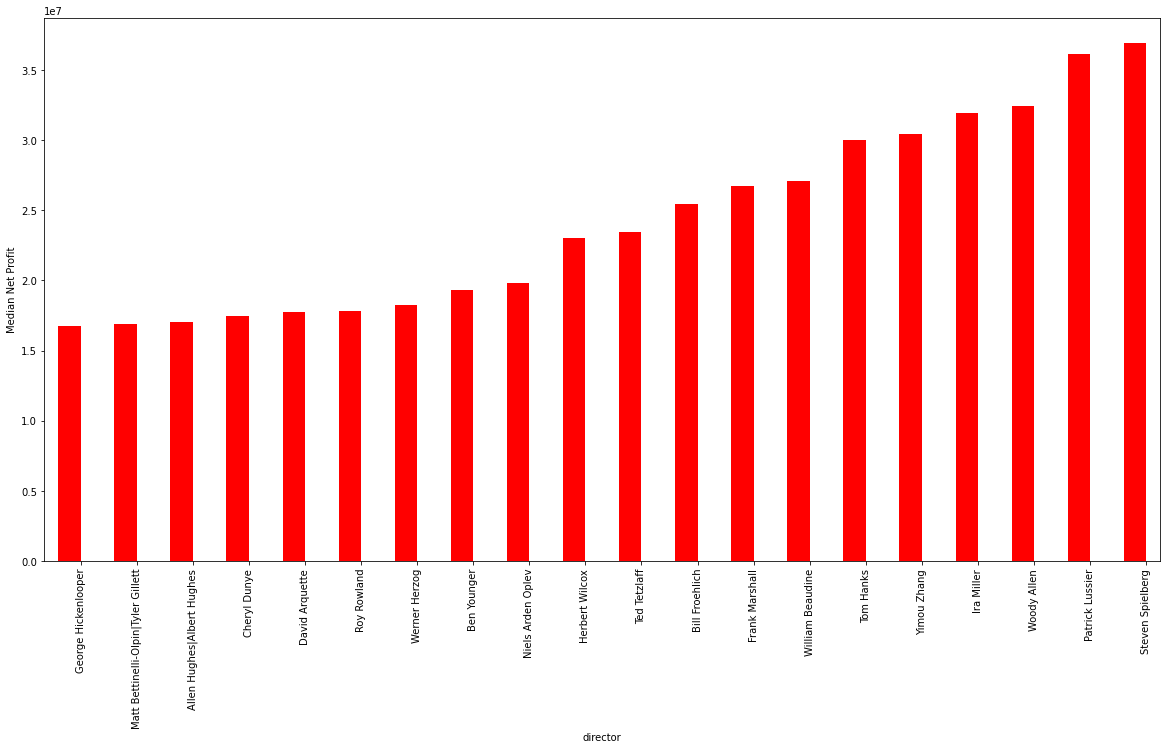

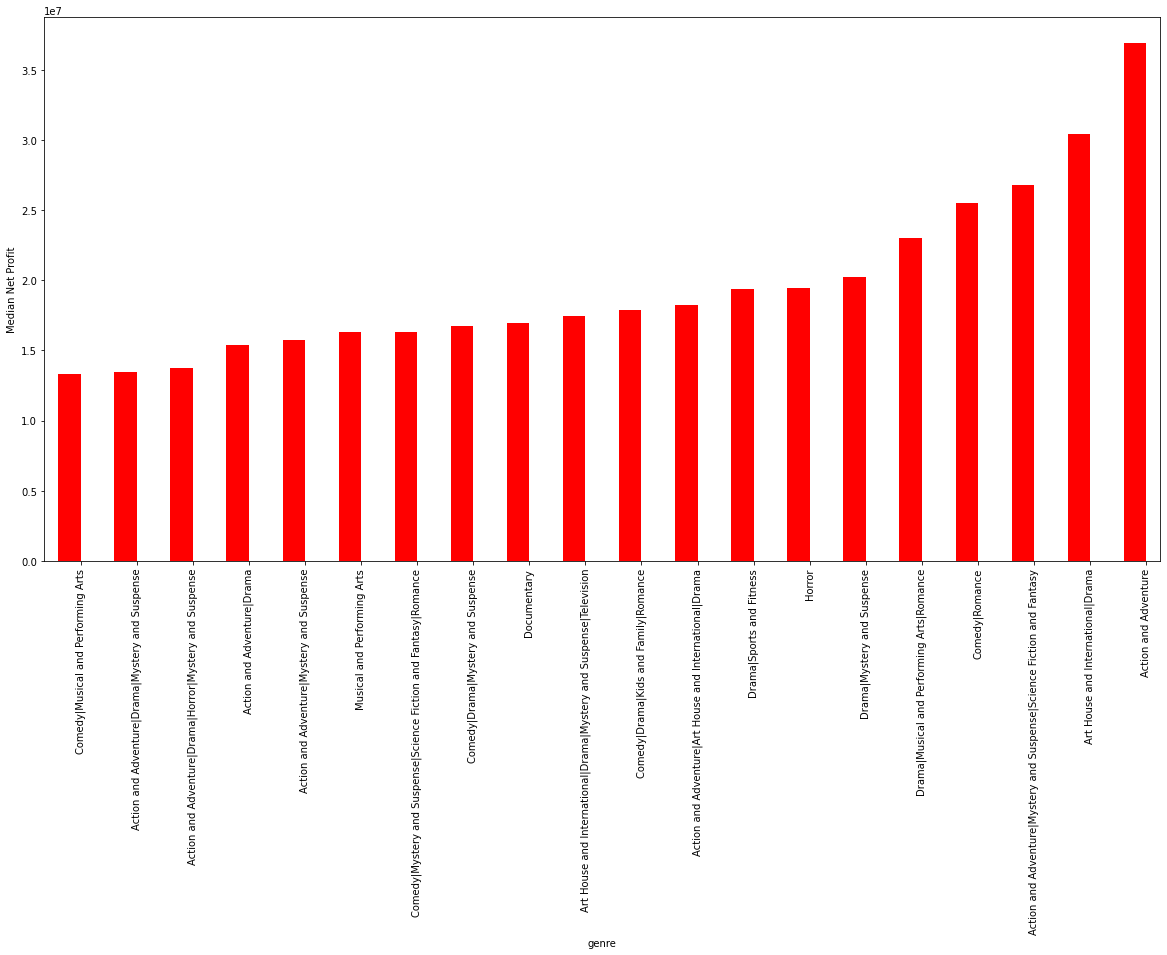

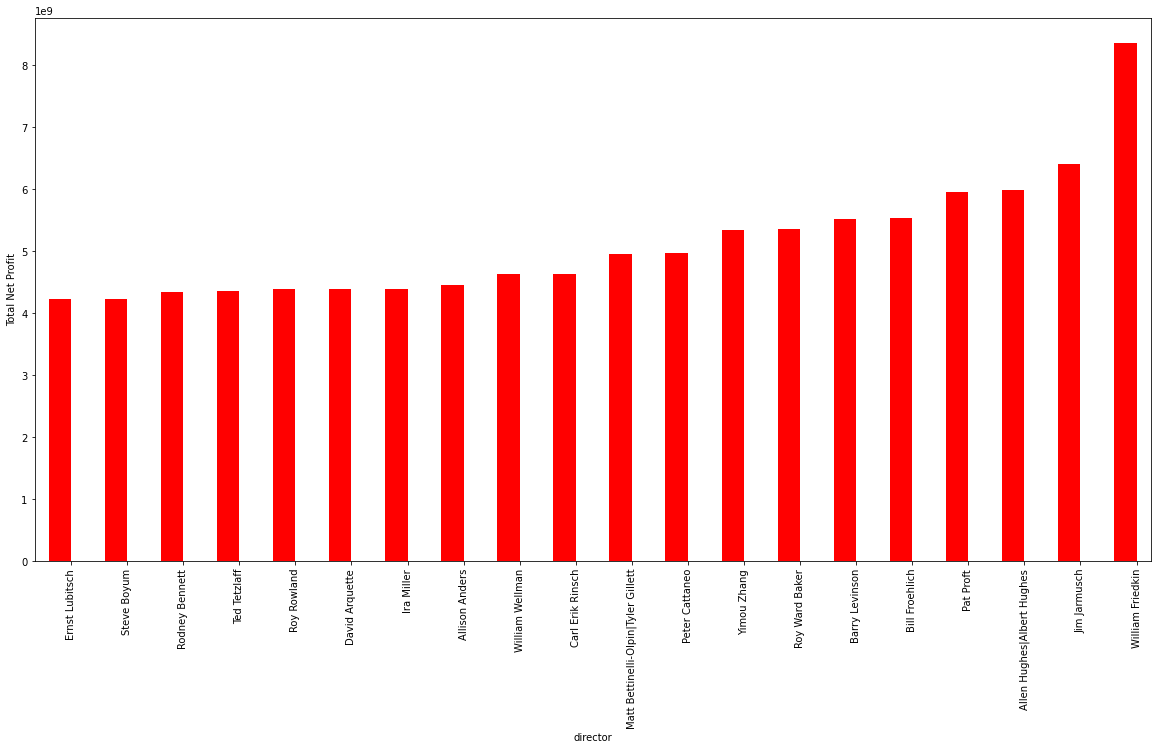

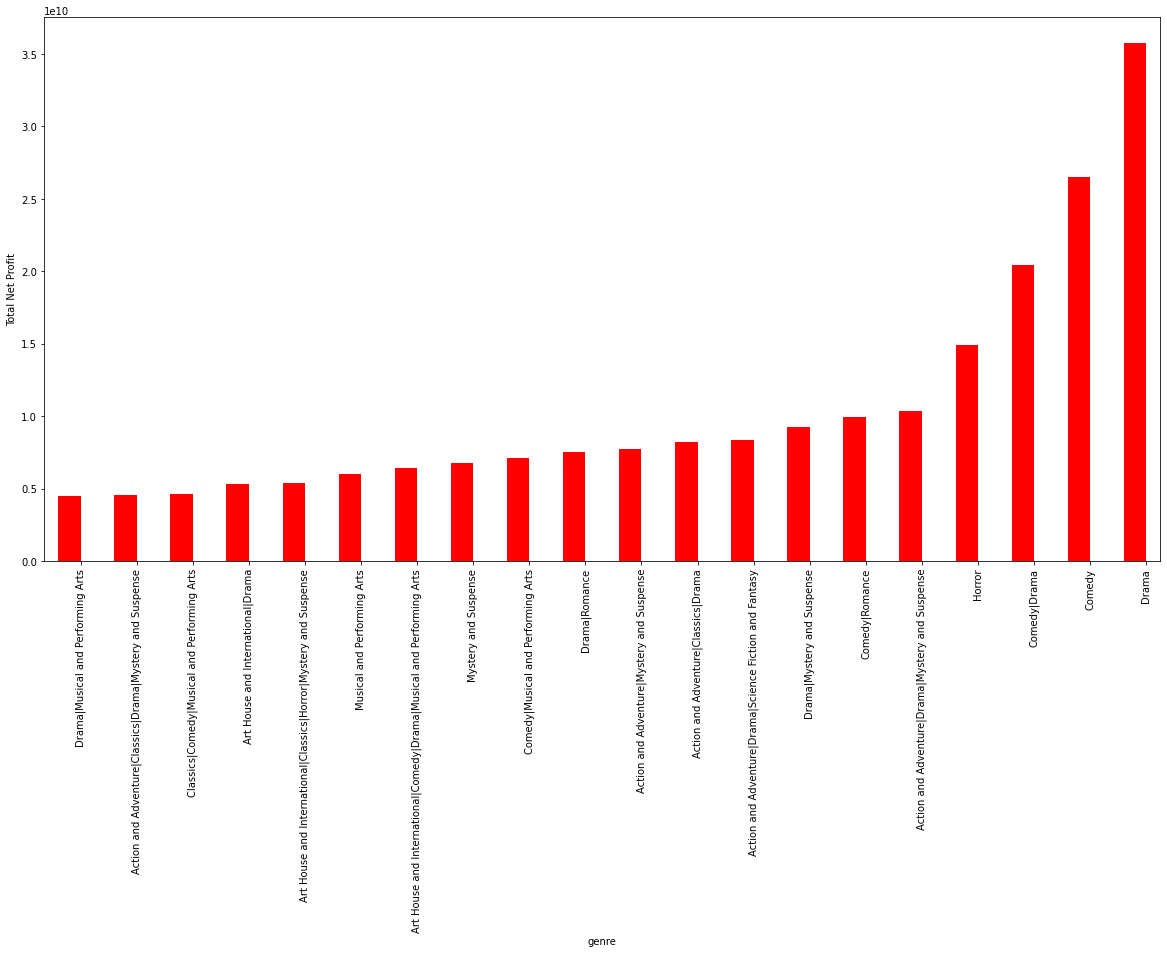

In [174]:
# aggregations
# medians to reduce outliers from means, total net by categories - genre, director, writer 
# total is actually what we want to use as it shows us TAM size 
# median can be thrown off by genres & directors with lots of hits & lots of misses that sum up to lower total
# drama, comedy and horror are more consistent hit makers than action, adventure, art-house, foreign, rom-com & sci-fi/fantasy

# TODO: directors for drama, comedy, drama/comedy & horror
# TODO: change budgets join to use movie title not ID, as ID is bad
#       need to join genre from another source 
# TODO: scatter net2022 vs length
# TODO: change bar chart to the type with range lines on it 

med_dir = joinedup[['director','net2022']].groupby('director').median()
med_dir = med_dir.sort_values(by=['net2022']).tail(20)
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
med_dir.net2022.plot(kind='bar', color='red', ax=ax, width=width, position=1)
ax.set_ylabel('Median Net Profit')
plt.show()

med_gen = joinedup[['genre','net2022']].groupby('genre').median()
med_gen = med_gen.sort_values(by=['net2022']).tail(20)
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
med_gen.net2022.plot(kind='bar', color='red', ax=ax, width=width, position=1)
ax.set_ylabel('Median Net Profit')
plt.show()


sum_dir = joinedup[['director','net2022']].groupby('director').sum()
sum_dir = sum_dir.sort_values(by=['net2022']).tail(20)
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
sum_dir.net2022.plot(kind='bar', color='red', ax=ax, width=width, position=1)
ax.set_ylabel('Total Net Profit')
plt.show()

sum_gen = joinedup[['genre','net2022']].groupby('genre').sum()
sum_gen = sum_gen.sort_values(by=['net2022']).tail(20)
plt.rcParams['figure.figsize'] = (20, 10)
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
width = 0.4
sum_gen.net2022.plot(kind='bar', color='red', ax=ax, width=width, position=1)
ax.set_ylabel('Total Net Profit')
plt.show()




In [187]:
joinedup.loc[joinedup['director'] == 'Ira Miller']
# movie where director looks wrong and is not Ira Miller
# Dunkirk = Christopher Nolan 
# Sex and the City = Michael Patrick King 
# (175 more examples)

# only 1 movie here with id = 69
info.loc[info['director'] == 'Ira Miller']

# ID re-use??
budgets.loc[budgets['movie']=='Dunkirk']
# id = 69 
budgets

,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
...,...,...,...,...,...
78,"Dec 31, 2018",Red 11,"$7,000",$0,$0
79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"


In [ ]:
pd.read_sql("""
SELECT *
  FROM XX
  WHERE YY;
""", conn)





conn.close()